In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import qiskit
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

In [2]:
# def generate_random_circuit(circ, n_qubit, depth):

#     for i in range(n_qubit):
#         circ.ry(np.pi/4, i)

#     for d in range(depth):
#         # add random single qubit gates
#         for qubit in range(n_qubit):
#             random_n   = np.random.randint(0, 8)
#             random_rot = np.random.uniform(0, 2*np.pi)

#             if random_n == 0:
#                 circ.rx(random_rot, qubit)
#             elif random_n == 1:
#                 circ.ry(random_rot, qubit)
#             elif random_n == 2:
#                 circ.rz(random_rot, qubit)
#             elif random_n == 3:
#                 circ.h(qubit)
#             else:
#                 pass
        
#         # add random double qubit gates
#         for src, dst in combinations(range(n_qubit), 2):
#             random_n = np.random.randint(0, 6)

#             if random_n == 0:
#                 circ.cx(src, dst)
#             elif random_n == 1:
#                 circ.cx(dst, src)
#             elif random_n == 2:
#                 circ.swap(src, dst)
#             else:
#                 pass

#     return circ

In [3]:
# qc = qiskit.QuantumCircuit(3)
# qc = generate_random_circuit(qc, 3, 2)
# qc.draw('mpl')

In [6]:
class QuanvFilterCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, filter_size, backend, shots, threshold):
        # --- Circuit definition start ---
        self.n_qubits = filter_size ** 2

        self._circuit = qiskit.QuantumCircuit(self.n_qubits)

        # self.theta0 = qiskit.circuit.Parameter('theta0')
        # self.theta1 = qiskit.circuit.Parameter('theta1')
        # self.theta2 = qiskit.circuit.Parameter('theta2')
        # self.theta3 = qiskit.circuit.Parameter('theta3')
        
        # self._circuit.rx(self.theta0, 0)
        # self._circuit.rx(self.theta1, 1)
        # self._circuit.rx(self.theta2, 2)
        # self._circuit.rx(self.theta3, 3)
        
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        self._circuit.barrier()

        # self._circuit = generate_random_circuit(self._circuit, self.n_qubits, 2)
        self._circuit += random_circuit(self.n_qubits, 2)

        self._circuit.measure_all()
        # --- Circuit definition end ---

        self.backend   = backend
        self.shots     = shots
        self.threshold = threshold

    def run(self, data):
        # val > self.threshold  : |1> - rx(pi)
        # val <= self.threshold : |0> - rx(0)
        thetas = []
        for dat in data:
            theta = []
            for val in dat:
                if val > self.threshold:
                    theta.append(np.pi)
                else:
                    theta.append(0)
            thetas.append(theta)
        
        param_dict = dict()

        for theta in thetas:
            for i in range(self.n_qubits):
                param_dict[self.theta[i]] = theta[i]

        param_binds = [param_dict]

        # param_binds = [{self.theta0: theta[0], 
        #                 self.theta1: theta[1], 
        #                 self.theta2: theta[2], 
        #                 self.theta3: theta[3]} for theta in thetas]

        print(param_binds)

        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots, 
                             parameter_binds = param_binds)
        result = job.result().get_counts(self._circuit)

        counts = 0
        for key, val in result.items():
            cnt = sum([int(char) for char in key])
            counts += cnt * val

        # Compute probabilities for each state
        probabilities = counts / self.shots
        
        return np.array([probabilities])

[{Parameter(theta0): 0, Parameter(theta1): 0, Parameter(theta2): 0, Parameter(theta3): 3.141592653589793}]
[2.37]


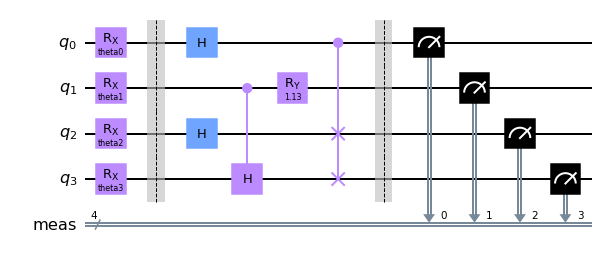

In [10]:
# test code for class QuanvFilterCiruit
backend = qiskit.Aer.get_backend('qasm_simulator')
circ = QuanvFilterCircuit(2, backend, 100, 127)

data = torch.tensor([[0, 0, 0, 255]])

print(circ.run(data))

circ._circuit.draw(output='mpl')

In [38]:
# Concentrating on the first 100 samples
n_samples = 128
batch_size = 32

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)


In [6]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [7]:
n_samples = 256

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # <- Quanv!!!!
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

In [9]:
model = Net()
summary(model, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
         Dropout2d-3             [-1, 16, 4, 4]               0
            Linear-4                   [-1, 64]          16,448
            Linear-5                   [-1, 10]             650
Total params: 19,670
Trainable params: 19,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.08
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)

        # print("data  ", data.size())
        # print("output", output.size())
        # print("target", target.size())

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: 2.3077
Training [10%]	Loss: 2.2989
Training [15%]	Loss: 2.2886
Training [20%]	Loss: 2.2771
Training [25%]	Loss: 2.2540
Training [30%]	Loss: 2.2504
Training [35%]	Loss: 2.2358
Training [40%]	Loss: 2.2009
Training [45%]	Loss: 2.1884
Training [50%]	Loss: 2.1690
Training [55%]	Loss: 2.1246
Training [60%]	Loss: 2.0927
Training [65%]	Loss: 2.0198
Training [70%]	Loss: 1.9811
Training [75%]	Loss: 1.9052
Training [80%]	Loss: 1.9004
Training [85%]	Loss: 1.8731
Training [90%]	Loss: 1.8472
Training [95%]	Loss: 1.8225
Training [100%]	Loss: 1.8234


Text(0, 0.5, 'Neg Log Likelihood Loss')

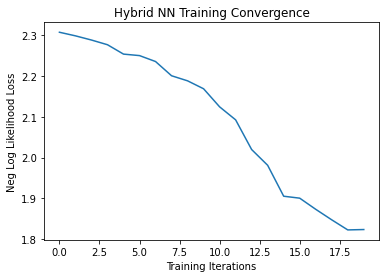

In [11]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [13]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )

Performance on test data:
	Loss: 1.8659
	Accuracy: 64.8%


In [14]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1